In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import json

from datetime import datetime

import statsmodels.api as sm

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima.arima.utils import ndiffs

from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import pickle

# Reading in data

In [72]:
italy_17_19 = pd.read_pickle('../data/it_17_19_v50_feat.pkl')
spain_17_19 = pd.read_pickle('../data/sp_17_19_v50_feat.pkl')
greece_17_19 = pd.read_pickle('../data/gr_17_19_v50_feat.pkl')

italy_20 = pd.read_pickle('../data/it_20_v50_feat.pkl')
spain_20 = pd.read_pickle('../data/sp_20_v50_feat.pkl')
greece_20 = pd.read_pickle('../data/gr_20_v50_feat.pkl')

In [73]:
spain_20.tail(2)

,Position,Track Name,Artist,region,spotify_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,,,,,
2021-02-13,49,La Luz - A COLORS SHOW,María José Llergo,es,5jRnVQbjB6qgN3MARS4xw7,0.722,0.357,9,-10.487,0,0.0996,0.81400,0.155000,0.0863,0.641,149.895,191599,4
2021-02-13,50,Boku no Sensou - TV Size,Shinsei Kamattechan,es,3tRPfCFAEv6wWyQO0YnGGV,0.447,0.891,9,-4.776,1,0.0788,0.00447,0.000905,0.3900,0.517,143.976,90960,4


# Preprocessing data 

#### _Data for each country is split into different dataframes as different combinations and aggregations are needed for different functions._ 

**Resampling by month**

_`rm` denotes resampling by month._ 

In [74]:
rm_italy_17_19 = italy_17_19.resample("M").mean()
rm_spain_17_19 = spain_17_19.resample("M").mean()
rm_greece_17_19 = greece_17_19.resample("M").mean()

rm_italy_20 = italy_20.resample("M").mean()
rm_spain_20 = spain_20.resample("M").mean()
rm_greece_20 = greece_20.resample("M").mean()

**Resampling by week**

_`rw` denotes resampling by week._ 

In [75]:
rw_italy_17_19 = italy_17_19.resample("W").mean()
rw_spain_17_19 = spain_17_19.resample("W").mean()
rw_greece_17_19 = greece_17_19.resample("W").mean()

rw_italy_20 = italy_20.resample("W").mean()
rw_spain_20 = spain_20.resample("W").mean()
rw_greece_20 = greece_20.resample("W").mean()

#### Combining weekly resampled data for all years (2017-2020)

In [76]:
alltime_italy = pd.concat([italy_17_19, italy_20])
alltime_spain = pd.concat([spain_17_19, spain_20])
alltime_greece = pd.concat([greece_17_19, greece_20])

alltime_rw_italy = alltime_italy.resample("W").mean()
alltime_rw_spain = alltime_spain.resample("W").mean()
alltime_rw_greece = alltime_greece.resample("W").mean()

#### Splitting into dataframes for each year! 

In [77]:
it_rw_17 = alltime_rw_italy[0:53]
it_rw_18 = alltime_rw_italy[53:105]
it_rw_19 = alltime_rw_italy[105:158]

In [78]:
it_rw_19.tail(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,
2019-12-29,25.5,0.666363,0.610831,6.125714,-7.189337,0.637143,0.109331,0.278767,0.041290,0.171111,0.460510,117.949174,190365.777143,3.965714
2020-01-05,25.5,0.695900,0.643483,6.314286,-6.612169,0.634286,0.127259,0.225605,0.030068,0.184051,0.476149,118.608006,188407.960000,3.962857


# Differencing Data for Stationarity

### Augmented Dickey-Fuller test to estimate whether data are stationary. 

In [79]:
audio_features = [
'danceability', 
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo']

In [80]:
# Code by Joseph Nelson! 

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic', 'p-value', 'lags_used'])
    return dfoutput

_Dickey-Fuller on original dataframes_

In [81]:
for feature in audio_features:
    print(f'Dickey-Fuller Interpretation for {feature}:\n{interpret_dftest(adfuller(it_rw_18[feature]))}')

Dickey-Fuller Interpretation for danceability:
Test Statistic   -2.978150
p-value           0.036986
lags_used         1.000000
dtype: float64
Dickey-Fuller Interpretation for energy:
Test Statistic   -3.24877
p-value           0.01733
lags_used         0.00000
dtype: float64
Dickey-Fuller Interpretation for key:
Test Statistic   -3.469608
p-value           0.008803
lags_used         4.000000
dtype: float64
Dickey-Fuller Interpretation for loudness:
Test Statistic   -3.003203
p-value           0.034596
lags_used         0.000000
dtype: float64
Dickey-Fuller Interpretation for mode:
Test Statistic   -4.432011
p-value           0.000260
lags_used         0.000000
dtype: float64
Dickey-Fuller Interpretation for speechiness:
Test Statistic    -1.736793
p-value            0.412262
lags_used         10.000000
dtype: float64
Dickey-Fuller Interpretation for acousticness:
Test Statistic   -2.390354
p-value           0.144477
lags_used         0.000000
dtype: float64
Dickey-Fuller Interpretatio

### DataFrame with once-differenced data

In [82]:
lag_df_italy = alltime_rw_italy.copy()

In [83]:
for feature in audio_features: 
    lag_df_italy[f'{feature}_once_differenced'] = lag_df_italy[feature].diff(1).fillna(0)

In [84]:
lag_df_italy.tail(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,energy_once_differenced,key_once_differenced,loudness_once_differenced,mode_once_differenced,speechiness_once_differenced,acousticness_once_differenced,instrumentalness_once_differenced,liveness_once_differenced,valence_once_differenced,tempo_once_differenced
date,,,,,,,,,,,,,,,,,,,,,
2021-02-07,25.5,0.666561,0.634389,5.402857,-6.677991,0.680000,0.109192,0.268234,0.035348,0.223654,...,0.029374,0.18000,0.314663,0.031429,-0.001159,-0.073344,-0.001695,0.005719,-0.006398,3.285271
2021-02-14,25.5,0.671104,0.647343,5.516667,-6.842603,0.656667,0.120716,0.277941,0.054173,0.220087,...,0.012955,0.11381,-0.164612,-0.023333,0.011523,0.009707,0.018826,-0.003567,0.049983,1.041837


_Dickey-Fuller on lag dataframe_

In [85]:
for feature in audio_features:
    print(f'Dickey-Fuller Interpretation for {feature}, once-differenced:\n{interpret_dftest(adfuller(lag_df_italy[feature].diff(1).fillna(0)))}')

Dickey-Fuller Interpretation for danceability, once-differenced:
Test Statistic   -9.142255e+00
p-value           2.828632e-15
lags_used         5.000000e+00
dtype: float64
Dickey-Fuller Interpretation for energy, once-differenced:
Test Statistic   -6.782611e+00
p-value           2.477455e-09
lags_used         7.000000e+00
dtype: float64
Dickey-Fuller Interpretation for key, once-differenced:
Test Statistic   -8.518281e+00
p-value           1.118537e-13
lags_used         7.000000e+00
dtype: float64
Dickey-Fuller Interpretation for loudness, once-differenced:
Test Statistic   -7.002232e+00
p-value           7.272028e-10
lags_used         6.000000e+00
dtype: float64
Dickey-Fuller Interpretation for mode, once-differenced:
Test Statistic   -9.845662e+00
p-value           4.627101e-17
lags_used         4.000000e+00
dtype: float64
Dickey-Fuller Interpretation for speechiness, once-differenced:
Test Statistic   -8.291616e+00
p-value           4.246658e-13
lags_used         5.000000e+00
dtype

_Checking that these are the same_

In [86]:
interpret_dftest(adfuller(lag_df_italy['energy_once_differenced']))

Test Statistic   -6.782611e+00
p-value           2.477455e-09
lags_used         7.000000e+00
dtype: float64

In [87]:
interpret_dftest(adfuller(lag_df_italy['energy'].diff(1).fillna(0)))

Test Statistic   -6.782611e+00
p-value           2.477455e-09
lags_used         7.000000e+00
dtype: float64

### Using `ndiffs` to figure out how many orders of difference $d$ I need in oder to have stationarity

#### _Running `ndiff` and `p,d,q` functions just on 2019 Italy data instead of alltime Italy data; however I will just be checking it out; will leave the `ndiff_dict` and `ndiff_df` as is because that is use in models. Will use 2019 data to build the `ndiff_df` to see if this yields better results for this year._ 

In [88]:
from pmdarima.arima.utils import ndiffs

In [89]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ adf test: {ndiffs(alltime_italy[feature], test= "adf")}')

ndiffs for danceability stationarity w/ adf test: 0
ndiffs for energy stationarity w/ adf test: 0
ndiffs for key stationarity w/ adf test: 0
ndiffs for loudness stationarity w/ adf test: 0
ndiffs for mode stationarity w/ adf test: 0
ndiffs for speechiness stationarity w/ adf test: 0
ndiffs for acousticness stationarity w/ adf test: 0
ndiffs for instrumentalness stationarity w/ adf test: 0
ndiffs for liveness stationarity w/ adf test: 0
ndiffs for valence stationarity w/ adf test: 0
ndiffs for tempo stationarity w/ adf test: 0


In [90]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ adf test: {ndiffs(it_rw_19[feature], test= "adf")}')

ndiffs for danceability stationarity w/ adf test: 1
ndiffs for energy stationarity w/ adf test: 1
ndiffs for key stationarity w/ adf test: 1
ndiffs for loudness stationarity w/ adf test: 1
ndiffs for mode stationarity w/ adf test: 2
ndiffs for speechiness stationarity w/ adf test: 1
ndiffs for acousticness stationarity w/ adf test: 2
ndiffs for instrumentalness stationarity w/ adf test: 1
ndiffs for liveness stationarity w/ adf test: 1
ndiffs for valence stationarity w/ adf test: 1
ndiffs for tempo stationarity w/ adf test: 1


In [91]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ kpss test: {ndiffs(alltime_italy[feature])}')

ndiffs for danceability stationarity w/ kpss test: 1
ndiffs for energy stationarity w/ kpss test: 1
ndiffs for key stationarity w/ kpss test: 1
ndiffs for loudness stationarity w/ kpss test: 1
ndiffs for mode stationarity w/ kpss test: 1
ndiffs for speechiness stationarity w/ kpss test: 1
ndiffs for acousticness stationarity w/ kpss test: 1
ndiffs for instrumentalness stationarity w/ kpss test: 1
ndiffs for liveness stationarity w/ kpss test: 1
ndiffs for valence stationarity w/ kpss test: 1
ndiffs for tempo stationarity w/ kpss test: 1


In [92]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ kpss test: {ndiffs(it_rw_19[feature])}')

ndiffs for danceability stationarity w/ kpss test: 0
ndiffs for energy stationarity w/ kpss test: 1
ndiffs for key stationarity w/ kpss test: 1
ndiffs for loudness stationarity w/ kpss test: 1
ndiffs for mode stationarity w/ kpss test: 1
ndiffs for speechiness stationarity w/ kpss test: 0
ndiffs for acousticness stationarity w/ kpss test: 0
ndiffs for instrumentalness stationarity w/ kpss test: 0
ndiffs for liveness stationarity w/ kpss test: 0
ndiffs for valence stationarity w/ kpss test: 0
ndiffs for tempo stationarity w/ kpss test: 1


### Finding `p`, `d`, and `q` values

_Using only the five audio features that are the most relevant or show some sort of pattern_ 

In [93]:
five_features = ['danceability', 'mode', 'acousticness', 'valence', 'energy']

_Building dataframe with `ndifffs` for stationarity for each feature_

_This time using `it_rw_19` instead of `alltime_rw_italy`._

In [94]:
ndiff_dict = {
    'audio_feature':[],
    'ndiffs for stationarity':[]    
}

for feature in five_features:
    ndiff_dict['audio_feature'].append(feature)
    ndiff_dict['ndiffs for stationarity'].append(ndiffs(it_rw_19[feature], test= "adf"))

ndiff_df = pd.DataFrame(ndiff_dict)
ndiff_df

,audio_feature,ndiffs for stationarity
0,danceability,1
1,mode,2
2,acousticness,2
3,valence,1
4,energy,1


In [95]:
arima_dict_19 = {
    'audio_feature':[],
    'ndiffs(d)':[],
    'best_p':[],
    'best_q':[],
    'order':[],
    'ARIMA_model':[],
    'ARIMA_AIC':[]
}

def find_p_and_q(df, feature, arima_dict, n=6):
    
    '''
    For the specified data, finds the optimal values for the AutoRegressive term (p) and Moving Average term (q) to achieve better accuracy.
    '''
    
    train = df[feature][0:162]
    
    d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]

    # starting with large start AIC
    best_aic = 99 * (10 * 16)
    # creating variables to store best values ofd p and q 
    best_p = 0
    best_q = 0 

    # use nested for loop to iterate over values of p and q
    for p in range(n):

        for q in range(n):

            # insert try and and except statements
            try: 

                # fitting on ARIMA(p, 1, q) model 
                print(f'Attempting to fit ARIMA({p}, {d}, {q})')

                # instantiate ARIMA model
                arima = ARIMA(train, order=(p,d,q))

                # fit ARIMA model 
                model = arima.fit()

                # print out AIC for ARIMA(p, 1, q) model 
                print(f'For {feature}, the AIC for ARIMA({p},{d},{q}) is: {model.aic}')

                # Is this current model's AIC better than the OF best_aic? 
                if model.aic < best_aic:
                    # we want aic to be lower so we are setting a high aic and hoping for something lower 

                    # if it is, we overwrite the best_aic, best_p, and best_q
                    best_aic = model.aic
                    best_p = p 
                    best_q = q

            except:
                pass 

        order = (best_p, d, best_q)
    
    arima_dict['audio_feature'].append(feature)
    arima_dict['ndiffs(d)'].append(d)
    arima_dict['best_p'].append(best_p)
    arima_dict['best_q'].append(best_q)
    arima_dict['order'].append(order)
    arima_dict['ARIMA_model'].append(f'ARIMA({best_p},{d},{best_q})')
    arima_dict['ARIMA_AIC'].append(best_aic)

    print()
    print(f'{feature.upper()} MODEL FINISHED!')
    print(f'The model for {feature} that minimizes AIC on the training data is the ARIMA({best_p},{d},{best_q}).')
    print(f'The model has an aIC of {best_aic}.')
    print()

In [96]:
arima_dict_19

{'audio_feature': [],
 'ndiffs(d)': [],
 'best_p': [],
 'best_q': [],
 'order': [],
 'ARIMA_model': [],
 'ARIMA_AIC': []}

In [97]:
for feature in five_features:
    find_p_and_q(it_rw_19, feature, arima_dict_19)

Attempting to fit ARIMA(0, 1, 0)
For danceability, the AIC for ARIMA(0,1,0) is: -270.9695108618981
Attempting to fit ARIMA(0, 1, 1)
For danceability, the AIC for ARIMA(0,1,1) is: -270.3370488579727
Attempting to fit ARIMA(0, 1, 2)
For danceability, the AIC for ARIMA(0,1,2) is: -268.66695046927464
Attempting to fit ARIMA(0, 1, 3)
For danceability, the AIC for ARIMA(0,1,3) is: -267.83224464657917
Attempting to fit ARIMA(0, 1, 4)
For danceability, the AIC for ARIMA(0,1,4) is: -266.225159275186
Attempting to fit ARIMA(0, 1, 5)
For danceability, the AIC for ARIMA(0,1,5) is: -267.7595910879961
Attempting to fit ARIMA(1, 1, 0)
For danceability, the AIC for ARIMA(1,1,0) is: -270.13342080415975
Attempting to fit ARIMA(1, 1, 1)
For danceability, the AIC for ARIMA(1,1,1) is: -271.8078318641607
Attempting to fit ARIMA(1, 1, 2)
For danceability, the AIC for ARIMA(1,1,2) is: -269.8464154808887
Attempting to fit ARIMA(1, 1, 3)
For danceability, the AIC for ARIMA(1,1,3) is: -266.92848156776665
Attempt

In [98]:
arima_param_df_19 = pd.DataFrame(arima_dict_19)
arima_param_df_19

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC
0,danceability,1,1,1,"(1, 1, 1)","ARIMA(1,1,1)",-271.807832
1,mode,2,1,1,"(1, 2, 1)","ARIMA(1,2,1)",-157.890865
2,acousticness,2,5,1,"(5, 2, 1)","ARIMA(5,2,1)",-223.192159
3,valence,1,0,0,"(0, 1, 0)","ARIMA(0,1,0)",-255.848982
4,energy,1,1,1,"(1, 1, 1)","ARIMA(1,1,1)",-268.378718


# ARIMA Models  

### Function to create, evaluate, and plot `ARIMA` models 

In [99]:
def arima_predict_plot(df, feature, year, param_df, title='title', figsize=(15,5), order=None, d=None, ci=True):
    
    '''
    Fits ARIMA model and makes predictions for specified data. 
    Calculates test and train RMSE scores and appends to parameter dataframe.
    Plots actual values for train and test sets and predicted values for test set. 
    '''
  
    # create train and test sets
    n_rows = round(len(df)*0.9)
    train = df[feature][0:n_rows]
    test = df[feature][n_rows:]
    
    # find ndiffs for stationarity from ndiff dataframe
    if d is None: 
        d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]
    print(f'd = {d}')
    
    if order is None:
        # find order from arima parameters dataframe 
        order = param_df.loc[param_df['audio_feature'] == feature, 'order'].iloc[0]
    print(f'order = {order}')
   
    try: 
        # instantiate ARIMA model
        model = ARIMA(train, order=order)

        # fit ARIMA model
        arima = model.fit()

        # get predictions for train and test sets 
        preds_train = model.predict(params=arima.params, start=train.index[d], end=train.index[-1], typ='levels')
        preds_test = model.predict(params=arima.params, start=test.index[0], end=test.index[-1], typ='levels')

        # calculate and print RMSE for train and test setes 
        train_rmse = mean_squared_error(train[d::], preds_train)**0.5
        print(f'{feature.capitalize()} train RMSE ({year}) - ARIMA({order}): {train_rmse}')

        test_rmse = mean_squared_error(test, preds_test)**0.5
        print(f'{feature.capitalize()} test RMSE ({year}) - ARIMA({order}): {test_rmse}')

        # add RMSEs to arima parameters dataframe 
        param_df.loc[param_df['audio_feature'] == feature, 'arima_train_rmse'] = train_rmse    
        param_df.loc[param_df['audio_feature'] == feature, 'arima_test_rmse'] = test_rmse

          # set up plot
        plt.figure(figsize=figsize)

        # plot training data 
        plt.plot(train, color='blue')

        # plot testing data 
        plt.plot(test.index, test, color='orange')

        # plot predicted values for test set 
        plt.plot(test.index, preds_test, color='green')

        # add line for the baseline model (mean value of feature)
        plt.hlines(df[feature].mean(), train.index[0], test.index[-1], color = 'grey')

        # plot confidence interval
        if ci:
            ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
            plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 

        # make plot with title! 
        plt.title(title, fontsize=16)
        plt.show() ; 
        
    except:
        print(ValueError)
        pass

_Function soley for plotting to be used when needed._

In [100]:
def arima_plot(train, test, preds_test, title='title', figsize=(15,5), ci=True):
    
    # set up plot
    plt.figure(figsize=figsize)
    
    # plot training data 
    plt.plot(train, color='blue')
    
    # plot testing data 
    plt.plot(test.index, test, color='orange')
    
    # plot predicted values for test set 
    plt.plot(test.index, preds_test, color='green')
    
    # add line for the baseline model (mean value of feature)
    # plt.hlines(df[feature].mean(), train.index[0], test.index[-1], color = 'grey')
    
    # plot confidence interval 
    if ci:
        ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
        plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 
    
    # make plot with title! 
    plt.title(title, fontsize=16)
    plt.show() ; 

### ARIMA Models - 2019

_Using `arima_predict_plot` function to run ARIMA model for each feature and show plot of actual vs. test._

_This will also add columns for `arima_train_rmse` and `arima_test_rmse`._

In [101]:
it_rw_19.head(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,
2019-01-06,25.5,0.668231,0.680805,4.580000,-6.478111,0.514286,0.113994,0.288621,0.100187,0.153183,0.466531,126.070511,219218.028571,3.885714
2019-01-13,25.5,0.673357,0.677388,4.211429,-6.407583,0.522857,0.099184,0.289861,0.089097,0.150668,0.508239,124.737909,219014.757143,3.925714


In [102]:
it_rw_19.tail(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,
2019-12-29,25.5,0.666363,0.610831,6.125714,-7.189337,0.637143,0.109331,0.278767,0.041290,0.171111,0.460510,117.949174,190365.777143,3.965714
2020-01-05,25.5,0.695900,0.643483,6.314286,-6.612169,0.634286,0.127259,0.225605,0.030068,0.184051,0.476149,118.608006,188407.960000,3.962857


d = 1
order = (1, 1, 1)
Danceability train RMSE (2019) - ARIMA((1, 1, 1)): 0.015253564823005793
Danceability test RMSE (2019) - ARIMA((1, 1, 1)): 0.03758443837442127


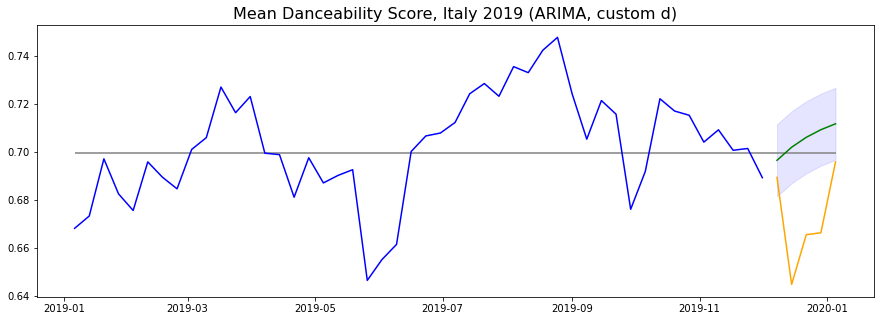

d = 2
order = (1, 2, 1)
Mode train RMSE (2019) - ARIMA((1, 2, 1)): 0.04616828639340792
Mode test RMSE (2019) - ARIMA((1, 2, 1)): 0.0813707111767709


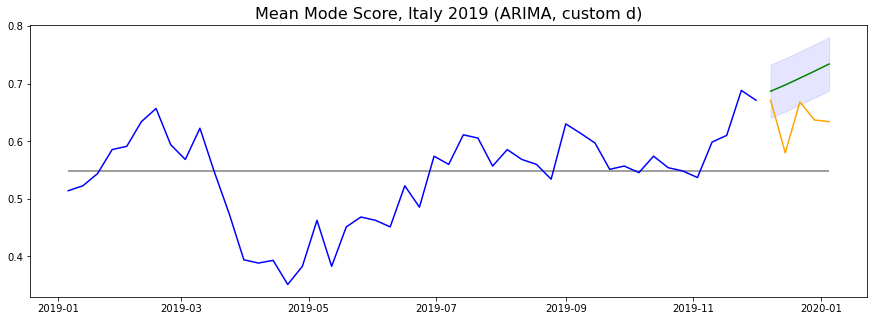

d = 2
order = (5, 2, 1)
Acousticness train RMSE (2019) - ARIMA((5, 2, 1)): 0.022119110081141393
Acousticness test RMSE (2019) - ARIMA((5, 2, 1)): 0.049119387814322735


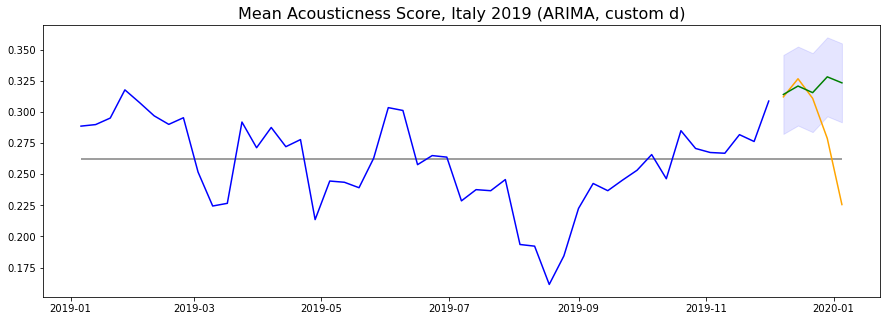

d = 1
order = (0, 1, 0)
Valence train RMSE (2019) - ARIMA((0, 1, 0)): 0.020456899728477224
Valence test RMSE (2019) - ARIMA((0, 1, 0)): 0.019087534748622053


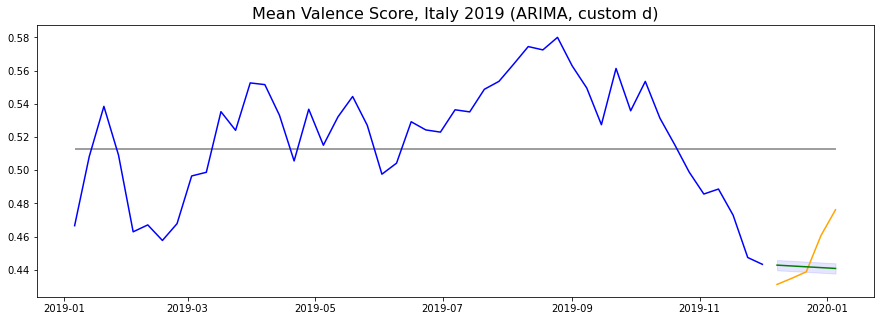

d = 1
order = (1, 1, 1)
Energy train RMSE (2019) - ARIMA((1, 1, 1)): 0.01691491191355239
Energy test RMSE (2019) - ARIMA((1, 1, 1)): 0.019290512937192087


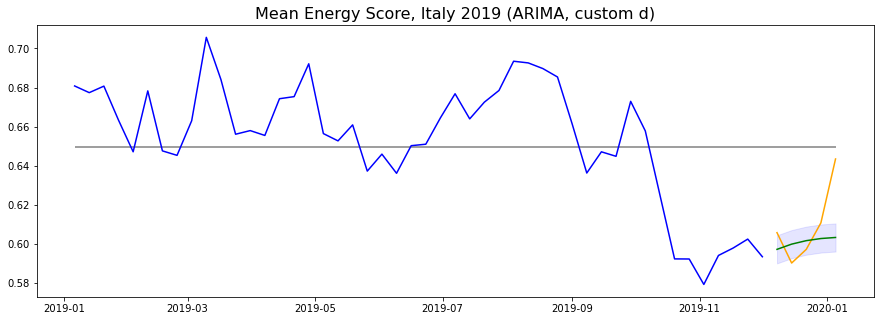

In [103]:
for feature in five_features: 
    arima_predict_plot(it_rw_19, feature, 2019, arima_param_df_19, title=f'Mean {feature.capitalize()} Score, Italy 2019 (ARIMA, custom d)')

#### _Updated `arima_param_df_19`_

In [104]:
arima_param_df_19

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC,arima_train_rmse,arima_test_rmse
0,danceability,1,1,1,"(1, 1, 1)","ARIMA(1,1,1)",-271.807832,0.015254,0.037584
1,mode,2,1,1,"(1, 2, 1)","ARIMA(1,2,1)",-157.890865,0.046168,0.081371
2,acousticness,2,5,1,"(5, 2, 1)","ARIMA(5,2,1)",-223.192159,0.022119,0.049119
3,valence,1,0,0,"(0, 1, 0)","ARIMA(0,1,0)",-255.848982,0.020457,0.019088
4,energy,1,1,1,"(1, 1, 1)","ARIMA(1,1,1)",-268.378718,0.016915,0.019291


# SARIMAX models 

In [105]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### _As baseline, Fitting SARIMAX with `seasonal_order = (2, 0, 2, 52)` and no exogenous variables before incorporating/engineering those components._

RMSE = 0.02


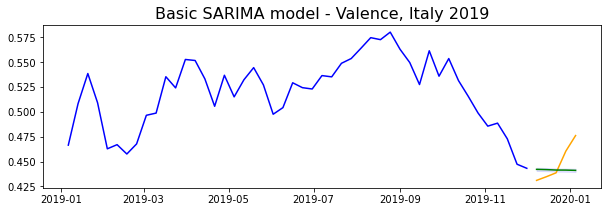

In [106]:
P, D, Q, S = 2, 0 ,2, 52
train_val = it_rw_19['valence'][0:48]
test_val = it_rw_19['valence'][48:]

sarima_val = SARIMAX(endog = train_val, order = (2, 0, 2), seasonal_order = (P, D, Q, S)).fit()
# sarima_pred = sarima.predict(start=start, end = end)

preds_train_sarima_val = sarima_val.predict(start=train_val.index[0], end=train_val.index[-1])
preds_test_sarima_val = sarima_val.predict(start=test_val.index[0], end=test_val.index[-1])

print(f'RMSE = {round(mean_squared_error(test_val, preds_test_sarima_val)**.5, 2)}')

arima_plot(train_val, test_val, preds_test_sarima_val, title="Basic SARIMA model - Valence, Italy 2019", figsize=(10,3))

#### Plotting ARIMA plot from above again, for comparison: 

d = 1
order = (2, 1, 2)
Valence train RMSE (2019) - ARIMA((2, 1, 2)): 0.036157040161561356
Valence test RMSE (2019) - ARIMA((2, 1, 2)): 0.04017210751841029


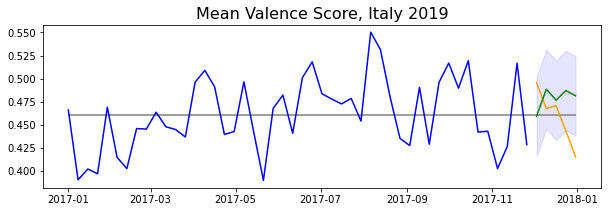

In [107]:
arima_predict_plot(it_rw_17, 'valence', 2019, arima_param_df_19, title=f'Mean Valence Score, Italy 2019', figsize=(10,3), order=(2,1,2))

### SARIMAX Seasonal Parameters

#### _Grid search to find best `P`, `D`, `Q`, and `s` values_

In [108]:
def find_sarima_parameters(df, feature, param_df, n_rows=47):    
    
    '''
    For specified data, finds the best seasonal order hyperparameters (P,D,Q,s) to achieve better accuracy for predictions. 
    '''
    
    import time
    t0 = time.time()
    final_mae = 1000000000000
    final_S = 0
    final_D = 0
    final_P = 0
    final_Q = 0
    
    # find order from arima parameters dataframe 
    order = param_df.loc[param_df['audio_feature'] == feature, 'order'].iloc[0]

    train_values = df[feature][0:n_rows]
    test_values = df[feature][n_rows:]

    for S in range(48,53):
        for D in range(2):
            for P in range(4):
                for Q in range(4):
                    print(f'Checking ({P}, {D}, {Q}, {S}) at {round(time.time() - t0)} seconds.')
                    try:
                        sarima = SARIMAX(endog = train_values,
                                         order = order,
                                         seasonal_order = (P, D, Q, S)).fit()

                        sarima_pred = sarima.predict(start=test_values.index[0], end=test_values.index[-1], typ='levels')

                        if mean_absolute_error(test_values, sarima_pred) < final_mae:
                            final_mae = mean_absolute_error(test_values, sarima_pred)
                            final_S = S
                            final_D = D
                            final_P = P
                            final_Q = Q

                        print(f'We just fit a SARIMAX(2, 0, 2)x({P}, {D}, {Q}, {S}) model with {mean_absolute_error(test_values, sarima_pred)} MAE and {mean_squared_error(test_values, sarima_pred)**0.5} RMSE.')

                    except:
                        print('problem!')
                        raise

    print()
    print(f'The final model for {feature} is SARIMAX(2, 0, 2)x({final_P}, {final_D}, {final_Q}, {final_S}).')
    print()

In [109]:
# five_features

# for feature in five_features: 
#     find_sarima_parameters(it_rw_19, feature, arima_param_df_19)

Encounted `linalgerror` while trying to run `find_sarima_parameters` on 2019 Italy data (`it_rw_19`). It did run for danceability, mode, and acousticness, and the `seasonal_order` output was similar to that which I found for the 2017. I will therefore use the same `seasonal_order` for each the audio as was determined by the 2017 data (`it_rw_19`). 

Results from the above for the 2017 data:
+ The final model for danceability is SARIMAX(2, 0, 2)x(3, 0, 0, 48).
+ The final model for mode is SARIMAX(2, 0, 2)x(1, 0, 1, 52).
+ The final model for acousticness is SARIMAX(2, 0, 2)x(1, 0, 2, 48).
+ The final model for valence is SARIMAX(2, 0, 2)x(0, 0, 1, 49).
+ The final model for energy is SARIMAX(2, 0, 2)x(2, 0, 0, 49).

Results from SARIMA seasonal order grid search using 2017-2020 data:

+ The final model for danceability is SARIMAX(2, 0, 2)x(2, 0, 3, 48).
+ The final model for mode is SARIMAX(2, 0, 2)x(0, 0, 0, 48).
+ The final model for acousticness is SARIMAX(2, 0, 2)x(0, 1, 0, 48).
+ The final model for valence is SARIMAX(2, 0, 2)x(1, 0, 3, 50).
+ The final model for energy is SARIMAX(2, 0, 2)x(0, 0, 2, 51).

#### _Adding Seasonal Orders to `param_df`_

citation: converting string to tuple https://www.geeksforgeeks.org/python-convert-string-to-tuple/

In [110]:
arima_param_df_19.loc[arima_param_df_19['audio_feature'] == 'danceability', 'seasonal_order'] = '3, 0, 0, 48'
arima_param_df_19.loc[arima_param_df_19['audio_feature'] == 'mode', 'seasonal_order'] = '1, 0, 1, 52'
arima_param_df_19.loc[arima_param_df_19['audio_feature'] == 'acousticness', 'seasonal_order'] = '1, 0, 2, 48'
arima_param_df_19.loc[arima_param_df_19['audio_feature'] == 'valence', 'seasonal_order'] = '0, 0, 1, 49'
arima_param_df_19.loc[arima_param_df_19['audio_feature'] == 'energy', 'seasonal_order'] = '2, 0, 0, 49'

In [111]:
arima_param_df_19.loc[arima_param_df_19['audio_feature'] == 'danceability', 'seasonal_order_all_data'] = '2, 0, 3, 48'
arima_param_df_19.loc[arima_param_df_19['audio_feature'] == 'mode', 'seasonal_order_all_data'] = '0, 0, 0, 48'
arima_param_df_19.loc[arima_param_df_19['audio_feature'] == 'acousticness', 'seasonal_order_all_data'] = '0, 1, 0, 48'
arima_param_df_19.loc[arima_param_df_19['audio_feature'] == 'valence', 'seasonal_order_all_data'] = '1, 0, 3, 50'
arima_param_df_19.loc[arima_param_df_19['audio_feature'] == 'energy', 'seasonal_order_all_data'] = '0, 0, 2, 51'

#### _Updated `arima_param_df_19`_

In [112]:
arima_param_df_19

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC,arima_train_rmse,arima_test_rmse,seasonal_order,seasonal_order_all_data
0,danceability,1,1,1,"(1, 1, 1)","ARIMA(1,1,1)",-271.807832,0.015254,0.037584,"3, 0, 0, 48","2, 0, 3, 48"
1,mode,2,1,1,"(1, 2, 1)","ARIMA(1,2,1)",-157.890865,0.046168,0.081371,"1, 0, 1, 52","0, 0, 0, 48"
2,acousticness,2,5,1,"(5, 2, 1)","ARIMA(5,2,1)",-223.192159,0.022119,0.049119,"1, 0, 2, 48","0, 1, 0, 48"
3,valence,1,0,0,"(0, 1, 0)","ARIMA(0,1,0)",-255.848982,0.036157,0.040172,"0, 0, 1, 49","1, 0, 3, 50"
4,energy,1,1,1,"(1, 1, 1)","ARIMA(1,1,1)",-268.378718,0.016915,0.019291,"2, 0, 0, 49","0, 0, 2, 51"


#### _Seasonal order experiment (checking this out just on 2019 and 2020 data)_

_Modifying the two SARIMA functions below to use the seasonal order that is reflective of all the data instead of just 2017 data to see if this yields better results._ 

_This means replacing `seasonal_order` with `seasonal_order_all_data` from the `param_df`._ 

#### _Function for SARIMA w/ seasonal components, no exogenous variables:_

In [113]:
def sarima_predict_plot_seasonal(df, feature, year, param_df, title='title', figsize=(15,5), order=None, d=None, seasonal_order=None, ci=True):
    
    '''
    Fits SARIMA model and makes predictions for specified data. 
    Calculates test and train RMSE scores and appends to parameter dataframe.
    Plots actual values for train and test sets and predicted values for test set. 
    '''
  
    # create train and test sets
    n_rows = round(len(df)*0.9)
    train = df[feature][0:n_rows]
    test = df[feature][n_rows:]
    
    # find ndiffs for stationarity from ndiff dataframe
    if d is None: 
        d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]
    print(f'd = {d}')
    
    # find order from arima parameters dataframe 
    if order is None:
        order = param_df.loc[param_df['audio_feature'] == feature, 'order'].iloc[0]
    print(f'order = {order}')
    
    # find seasonal order from arima parameters dataframe 
    if seasonal_order is None: 
        sea_string = param_df.loc[param_df['audio_feature'] == feature, 'seasonal_order_all_data'].iloc[0]
        seasonal_order = tuple(map(int, sea_string.split(', '))) 
    print(f'seasonal order = {seasonal_order}')
    
    try: 

        # instantiate and fit SARIMAX model 
        sarima = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order).fit()

        # get predictions for train and test sets 
        preds_train = sarima.predict(start=train.index[d], end=train.index[-1], typ='levels')
        preds_test = sarima.predict(start=test.index[0], end=test.index[-1], typ='levels')

        # calculate and print RMSE for train and test setes 
        train_rmse = mean_squared_error(train[d::], preds_train)**0.5
        print(f'{feature.capitalize()} train RMSE ({year}) - SARIMA({order}): {train_rmse}')

        test_rmse = mean_squared_error(test, preds_test)**0.5
        print(f'{feature.capitalize()} test RMSE ({year}) - SARIMA({order}): {test_rmse}')    

        # add RMSEs to arima parameters dataframe 
        param_df.loc[param_df['audio_feature'] == feature, 'sarima_train_rmse_alltime_so'] = train_rmse    
        param_df.loc[param_df['audio_feature'] == feature, 'sarima_test_rmse_alltime_so'] = test_rmse

        # calculate residuals
        # residuals = test - preds_test

        # set up plot
        plt.figure(figsize=figsize)

        # plot training data 
        plt.plot(train, color='blue')

        # plot testing data 
        plt.plot(test.index, test, color='orange')

        # plot predicted values for test set 
        plt.plot(test.index, preds_test, color='green')

        # add line for the baseline model (mean value of feature)
        plt.hlines(df[feature].mean(), train.index[0], test.index[-1], color = 'grey')

        # plot confidence interval 
        if ci:
            ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
            plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 

        # make plot with title! 
        plt.title(title, fontsize=16)
        plt.show() ; 
        
    
    except ValueError as ve:
        print(ve)
        pass

In [114]:
def sarima_predict_plot_exog(df, feature, year, param_df, exog_var, title='title', figsize=(15,5), order=None, d=None, seasonal_order=None, ci=True):
    
    '''
    Fits SARIMAX model and makes predictions for specified data. 
    Calculates test and train RMSE scores and appends to parameter dataframe.
    Plots actual values for train and test sets and predicted values for test set. 
    '''

    # find ndiffs for stationarity from ndiff dataframe
    if d is None: 
        d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]
    print(f'd = {d}')
    
    # find order from arima parameters dataframe 
    if order is None:
        order = param_df.loc[param_df['audio_feature'] == feature, 'order'].iloc[0]
    print(f'order = {order}')
    
    # find seasonal order from arima parameters dataframe 
    if seasonal_order is None: 
        sea_string = param_df.loc[param_df['audio_feature'] == feature, 'seasonal_order_all_data'].iloc[0]
        seasonal_order = tuple(map(int, sea_string.split(', '))) 
    print(f'seasonal order = {seasonal_order}')
    
    # reshape exogenous features to pass to the model 
    exog = df.loc[:, exog_var]   
   
    # create train and test sets
    n_rows = round(len(df)*0.9)
    train = df[feature][0:n_rows]
    test = df[feature][n_rows:]
  
    try:
        # instantiate and fit SARIMAX model 
        sarima = SARIMAX(endog=train, exog=exog[0:n_rows], order=order, seasonal_order=seasonal_order).fit()

        # get predictions for train and test sets 
        preds_train = sarima.predict(start=train.index[d], end=train.index[-1], typ='levels', exog=exog[0:n_rows])
        preds_test = sarima.predict(start=test.index[0], end=test.index[-1], typ='levels', exog=exog[n_rows:])

        # calculate and print RMSE for train and test setes 
        train_rmse = mean_squared_error(train[d::], preds_train)**0.5
        print(f'{feature.capitalize()} train RMSE ({year}) - SARIMAX({seasonal_order}) w/ exogenous variables: {train_rmse}')

        test_rmse = mean_squared_error(test, preds_test)**0.5
        print(f'{feature.capitalize()} test RMSE ({year}) - SARIMAX({seasonal_order}) w/ exogenous variables: {test_rmse}')    

        # add RMSEs to arima parameters dataframe 
        param_df.loc[param_df['audio_feature'] == feature, 'exog_train_rmse_alltime_so'] = train_rmse    
        param_df.loc[param_df['audio_feature'] == feature, 'exog_test_rmse_alltime_so'] = test_rmse

        # calculate residuals
        # residuals = test - preds_test

        # set up plot
        plt.figure(figsize=figsize)

        # plot training data 
        plt.plot(train, color='blue')

        # plot testing data 
        plt.plot(test.index, test, color='orange')

        # plot predicted values for test set 
        plt.plot(test.index, preds_test, color='green')

        # add line for the baseline model (mean value of feature)
        plt.hlines(df[feature].mean(), train.index[0], test.index[-1], color = 'grey')

        # plot confidence interval 
        if ci:
            ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
            plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 

        # make plot with title! 
        plt.title(title, fontsize=16)
        plt.show() ; 
        
    except ValueError as ve:
        print(ve)
        pass

d = 1
order = (1, 1, 1)
seasonal order = (2, 0, 3, 48)
Danceability train RMSE (2019) - SARIMA((1, 1, 1)): 0.015382360121114737
Danceability test RMSE (2019) - SARIMA((1, 1, 1)): 0.028278372981484664


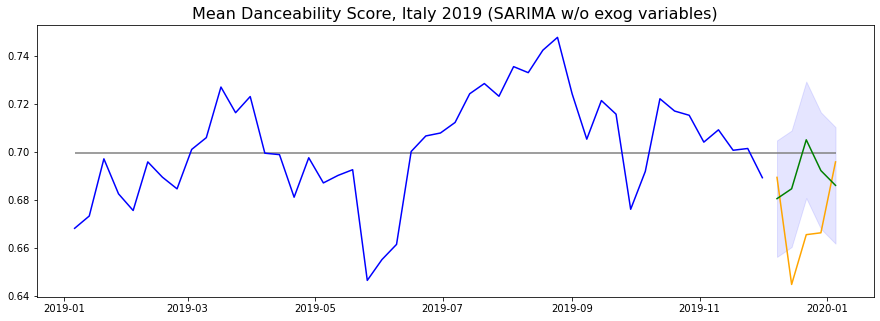

d = 2
order = (1, 2, 1)
seasonal order = (0, 0, 0, 48)
Mode train RMSE (2019) - SARIMA((1, 2, 1)): 0.04642933683964142
Mode test RMSE (2019) - SARIMA((1, 2, 1)): 0.05745476842775422


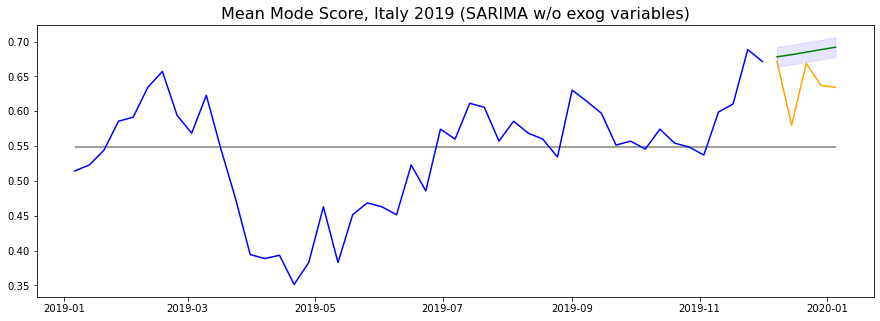

d = 2
order = (5, 2, 1)
seasonal order = (0, 1, 0, 48)
Acousticness train RMSE (2019) - SARIMA((5, 2, 1)): 0.03781163865517285
Acousticness test RMSE (2019) - SARIMA((5, 2, 1)): 0.07121491704099688


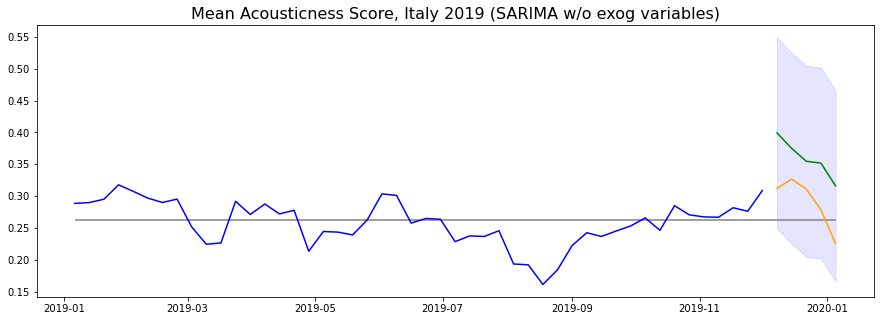

d = 1
order = (0, 1, 0)
seasonal order = (1, 0, 3, 50)
Valence train RMSE (2019) - SARIMA((0, 1, 0)): 0.02046289337146606
Valence test RMSE (2019) - SARIMA((0, 1, 0)): 0.017995309235962608


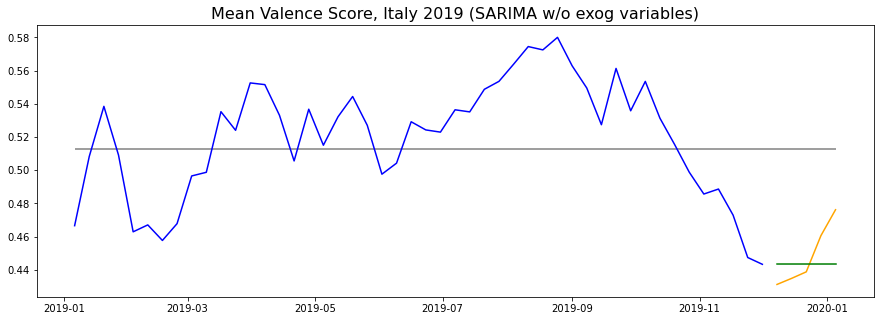

d = 1
order = (1, 1, 1)
seasonal order = (0, 0, 2, 51)
Energy train RMSE (2019) - SARIMA((1, 1, 1)): 0.01737670934945625
Energy test RMSE (2019) - SARIMA((1, 1, 1)): 0.019633714454451254


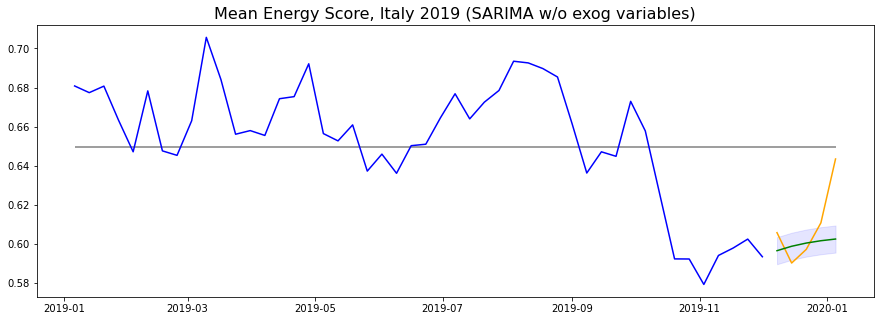

In [115]:
for feature in five_features:
    sarima_predict_plot_seasonal(it_rw_19, feature, 2019, arima_param_df_19, title=f'Mean {feature.capitalize()} Score, Italy 2019 (SARIMA w/o exog variables)')

#### _Updated `arima_param_df_19`_

In [116]:
arima_param_df_19

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC,arima_train_rmse,arima_test_rmse,seasonal_order,seasonal_order_all_data,sarima_train_rmse_alltime_so,sarima_test_rmse_alltime_so
0,danceability,1,1,1,"(1, 1, 1)","ARIMA(1,1,1)",-271.807832,0.015254,0.037584,"3, 0, 0, 48","2, 0, 3, 48",0.015382,0.028278
1,mode,2,1,1,"(1, 2, 1)","ARIMA(1,2,1)",-157.890865,0.046168,0.081371,"1, 0, 1, 52","0, 0, 0, 48",0.046429,0.057455
2,acousticness,2,5,1,"(5, 2, 1)","ARIMA(5,2,1)",-223.192159,0.022119,0.049119,"1, 0, 2, 48","0, 1, 0, 48",0.037812,0.071215
3,valence,1,0,0,"(0, 1, 0)","ARIMA(0,1,0)",-255.848982,0.036157,0.040172,"0, 0, 1, 49","1, 0, 3, 50",0.020463,0.017995
4,energy,1,1,1,"(1, 1, 1)","ARIMA(1,1,1)",-268.378718,0.016915,0.019291,"2, 0, 0, 49","0, 0, 2, 51",0.017377,0.019634


#### _Incorporating Exogenous Variables in SARIMAX models_

_Uses above function, `sarima_predict_plot_exog`_

_Identifying exogenous variables for each of the five main features, which for each of them is the other four audio features_

In [117]:
five_features = ['danceability', 'mode', 'acousticness', 'valence', 'energy']

exog_danceability = ['mode', 'acousticness', 'valence', 'energy']
exog_mode = ['danceability', 'acousticness', 'valence', 'energy']
exog_acousticness = ['danceability', 'mode', 'valence', 'energy']
exog_valence = ['danceability', 'mode', 'acousticness', 'energy']
exog_energy = ['danceability', 'mode', 'acousticness', 'valence']

d = 1
order = (1, 1, 1)
seasonal order = (2, 0, 3, 48)
Danceability train RMSE (2019) - SARIMAX((2, 0, 3, 48)) w/ exogenous variables: 0.012274065933527185
Danceability test RMSE (2019) - SARIMAX((2, 0, 3, 48)) w/ exogenous variables: 0.02437862751948803


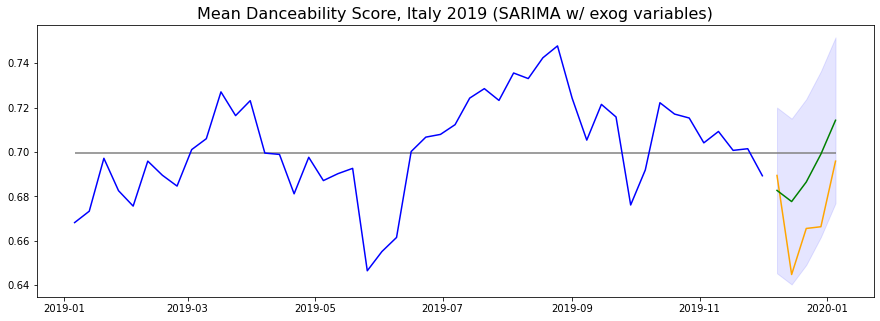

In [118]:
sarima_predict_plot_exog(it_rw_19, 'danceability', 2019, arima_param_df_19, exog_var=exog_danceability, title=f'Mean Danceability Score, Italy 2019 (SARIMA w/ exog variables)')

In [119]:
# for feature in five_features:
#     sarima_predict_plot_exog(it_rw_17, feature, 2019, exog_var=f'exog_{feature}', title=f'Mean {feature} Score, Italy 2019 (SARIMA w/ exog variables)')

d = 2
order = (1, 2, 1)
seasonal order = (0, 0, 0, 48)
Mode train RMSE (2019) - SARIMAX((0, 0, 0, 48)) w/ exogenous variables: 0.043274051840775526
Mode test RMSE (2019) - SARIMAX((0, 0, 0, 48)) w/ exogenous variables: 0.05443859146341619


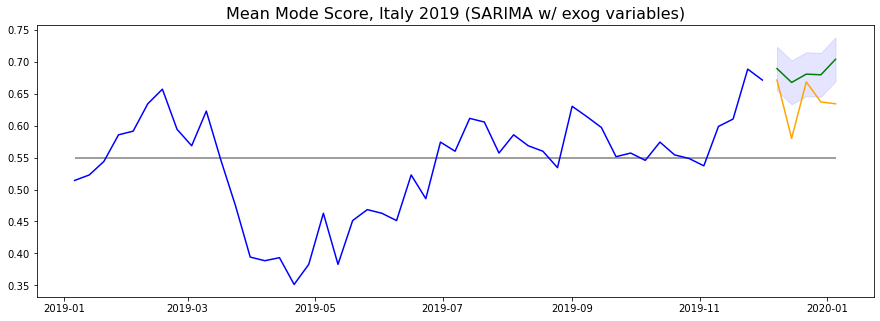

In [120]:
sarima_predict_plot_exog(it_rw_19, 'mode', 2019, arima_param_df_19, exog_var=exog_mode, title=f'Mean Mode Score, Italy 2019 (SARIMA w/ exog variables)')

d = 2
order = (5, 2, 1)
seasonal order = (0, 1, 0, 48)
Acousticness train RMSE (2019) - SARIMAX((0, 1, 0, 48)) w/ exogenous variables: 0.03781163865517285
Acousticness test RMSE (2019) - SARIMAX((0, 1, 0, 48)) w/ exogenous variables: 0.07121491704099688


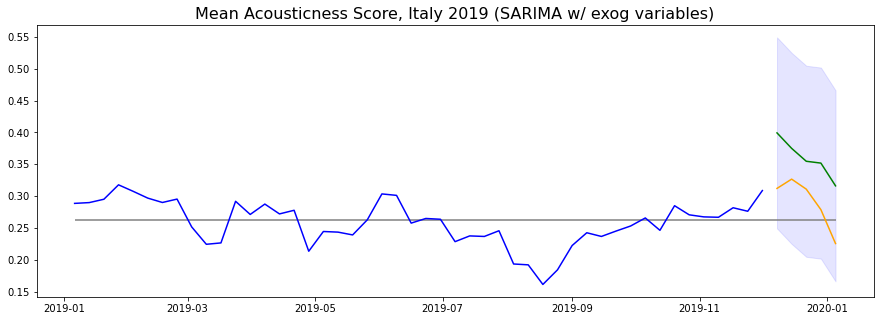

In [121]:
sarima_predict_plot_exog(it_rw_19, 'acousticness', 2019, arima_param_df_19, exog_var=exog_acousticness, title=f'Mean Acousticness Score, Italy 2019 (SARIMA w/ exog variables)')

d = 1
order = (0, 1, 0)
seasonal order = (1, 0, 3, 50)
Valence train RMSE (2019) - SARIMAX((1, 0, 3, 50)) w/ exogenous variables: 0.016472102184986098
Valence test RMSE (2019) - SARIMAX((1, 0, 3, 50)) w/ exogenous variables: 0.011218206589475966


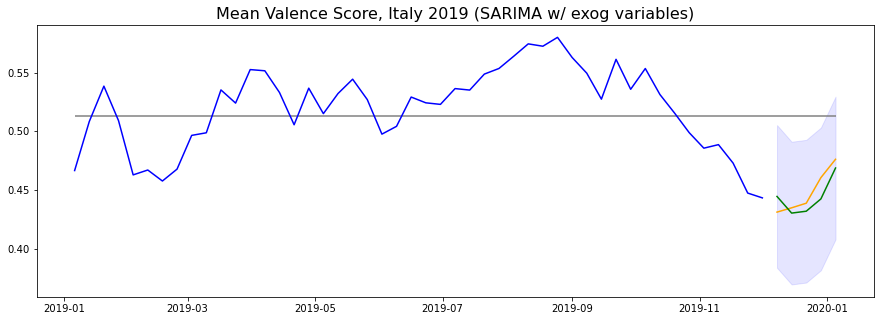

In [122]:
sarima_predict_plot_exog(it_rw_19, 'valence', 2019, arima_param_df_19, exog_var=exog_valence, title=f'Mean Valence Score, Italy 2019 (SARIMA w/ exog variables)')

d = 1
order = (1, 1, 1)
seasonal order = (0, 0, 2, 51)
Energy train RMSE (2019) - SARIMAX((0, 0, 2, 51)) w/ exogenous variables: 0.014138962891600762
Energy test RMSE (2019) - SARIMAX((0, 0, 2, 51)) w/ exogenous variables: 0.010980791958353303


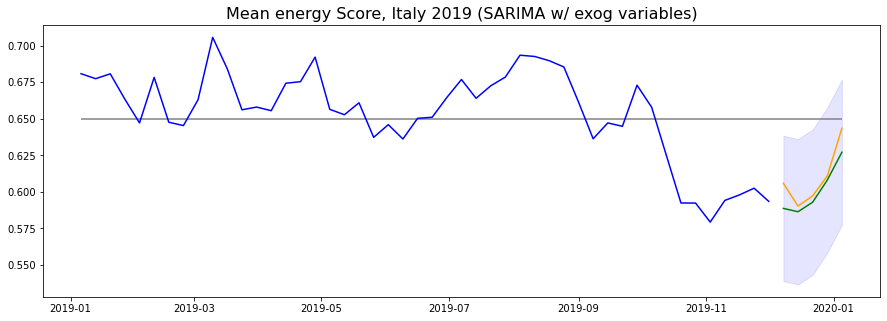

In [123]:
sarima_predict_plot_exog(it_rw_19, 'energy', 2019, arima_param_df_19, exog_var=exog_energy, title=f'Mean energy Score, Italy 2019 (SARIMA w/ exog variables)')

#### _Updated `arima_param_df_19`_

In [124]:
arima_param_df_19

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC,arima_train_rmse,arima_test_rmse,seasonal_order,seasonal_order_all_data,sarima_train_rmse_alltime_so,sarima_test_rmse_alltime_so,exog_train_rmse_alltime_so,exog_test_rmse_alltime_so
0,danceability,1,1,1,"(1, 1, 1)","ARIMA(1,1,1)",-271.807832,0.015254,0.037584,"3, 0, 0, 48","2, 0, 3, 48",0.015382,0.028278,0.012274,0.024379
1,mode,2,1,1,"(1, 2, 1)","ARIMA(1,2,1)",-157.890865,0.046168,0.081371,"1, 0, 1, 52","0, 0, 0, 48",0.046429,0.057455,0.043274,0.054439
2,acousticness,2,5,1,"(5, 2, 1)","ARIMA(5,2,1)",-223.192159,0.022119,0.049119,"1, 0, 2, 48","0, 1, 0, 48",0.037812,0.071215,0.037812,0.071215
3,valence,1,0,0,"(0, 1, 0)","ARIMA(0,1,0)",-255.848982,0.036157,0.040172,"0, 0, 1, 49","1, 0, 3, 50",0.020463,0.017995,0.016472,0.011218
4,energy,1,1,1,"(1, 1, 1)","ARIMA(1,1,1)",-268.378718,0.016915,0.019291,"2, 0, 0, 49","0, 0, 2, 51",0.017377,0.019634,0.014139,0.010981


#### _Pickling 2019 `arima_param_df_19` to compare with other years in another notebook_

In [125]:
arima_param_df_19.to_pickle('./metrics/2019_sarima_param_df_custom_so.pkl')

_Note about scaling: For each of the audio features I used, the songs were scored on a 0 to 1 scale. Therefore the weekly averages for each feature were also on the 0 to 1 scale, which meant that it was unnecessary to perform scaling on this data._